# Importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re

# Setting style parameters
palette = sns.color_palette('Spectral', 5)
palette.reverse()
sns.set_theme(style='white', palette=palette)

df_initial_data = pd.read_excel('./data_sources/Dataset Task 2.xlsx', sheet_name='Data')

palette

[(0.3280276816608997, 0.6805074971164936, 0.6802768166089965),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9139561707035756, 0.36239907727797, 0.27935409457900806)]

In [2]:
def clean_df(df):
    def clean_text(string):
        # Remove all characters that are not letters, numbers, or spaces
        cleaned_string = re.sub(r'[^\s\sA-Za-z0-9_\.]+', '', string)
        # Strip leading and trailing spaces and tabulations
        cleaned_string = cleaned_string.strip()
        cleaned_string = cleaned_string.capitalize()
        return cleaned_string

    def clean_column_name(name):
        # Delete all info in brackets and replace spaces with underscores
        name_no_brackets = re.sub(r'\[.*?\]', '', name)
        name_num_corrected = re.sub(r'#', 'num', name_no_brackets)
        name_normalized = re.sub(r'\s+', '_', name_num_corrected)
        # Apply clean_text to the column name
        cleaned_name = clean_text(name_normalized)
        # Ensure lowercase for consistency
        return cleaned_name.lower()

    # Clean and normalize column names first
    df.columns = [clean_column_name(col) for col in df.columns]

    for col in df.columns:
        # Determine if the column is string type
        if df[col].dtype == 'object':
            # Replace null values with empty string for string columns
            df[col] = df[col].fillna('')
            df[col] = df[col].apply(lambda x: clean_text(x) if isinstance(x, str) else x)
        else:
            # Determine if the column is numerical (float or int)
            if np.issubdtype(df[col].dtype, np.number):
                # Replace null values with 0 for numerical columns
                df[col] = df[col].fillna(0)
                
    return df

df_clean = clean_df(df_initial_data.copy())

In [3]:
# Adding weekday column to the dataframe to analyse dynamics of sales by week days.
df_clean['date'] = pd.to_datetime(df_clean['created_date'], infer_datetime_format=True)
df_clean['day_name'] = df_clean['date'].dt.day_name()
df_clean['weekday'] = df_clean['date'].dt.dayofweek + 1
df_clean['day_of_month'] = df_clean['date'].dt.day
df_clean['month_number'] = df_clean['date'].dt.month
df_clean[['date', 'day_name', 'weekday', 'month_number']].head(4)

,date,day_name,weekday,month_number
0,2020-02-28,Friday,5,2
1,2020-02-28,Friday,5,2
2,2020-02-28,Friday,5,2
3,2020-02-28,Friday,5,2


In [4]:
sorted(df_clean.columns)

['cancel_reason',
 'card_issuer',
 'city',
 'country',
 'created_date',
 'cuisine',
 'date',
 'day_name',
 'day_of_month',
 'delivery_fee',
 'delivery_time',
 'month_number',
 'order_state',
 'order_value__gross',
 'payment_method',
 'platform',
 'products_in_order',
 'restaurant_id',
 'restaurant_name',
 'weekday']

In [5]:
df_done = df_clean[df_clean.order_state == 'Delivered']

df_done.count()[0], df_clean.count()[0]

(97936, 99618)

# Research

## Values distribution
Let's quickly check how the values are distributed within various dimensions.

In [6]:
for c in df_clean.country.unique():
    print(c)

Portugal
Ghana


In [7]:
df_clean.order_state.unique()

array(['Delivered', 'Failed', 'Rejected'], dtype=object)

In [8]:
df = df_clean[df_clean.order_state != 'Delivered']

# Checking how orders are distributed within the reasons for both countries.
for c in df.country.unique():
    print(c)
    
    df_country = df[df.country == c]
    total = df_country.count()[0]

    display(
        df_country
        .groupby('cancel_reason')
        .agg(cancellations=('date','count'))
        .assign(total=total)
        .assign(share=lambda x: (x['cancellations']/x['total']*100).round(0).astype(int).astype(str) + '%')
    )
    print()

Portugal


,cancellations,total,share
cancel_reason,,,
Could not find a courier to deliver the order,206,901,23%
The restaurant asked customer support to fail the order,50,901,6%
The restaurant rejected the order,628,901,70%
User cancellation,17,901,2%



Ghana


,cancellations,total,share
cancel_reason,,,
Could not find a courier to deliver the order,146,781,19%
The restaurant asked customer support to fail the order,251,781,32%
The restaurant rejected the order,349,781,45%
User cancellation,35,781,4%


Ok, fine. In Ghana there are way more cases when restaurant asks customer support to cancel the order. This might affect rating calculation for restaurants and also the customer experience. Do we have specific cases that makes that difference?

In [9]:
df = df_clean[
    (df_clean.country == 'Ghana')
].copy()

total = df.count()[0]
df['cancelled_order'] = df.apply(lambda x: 1 if x['order_state']!='Delivered' else 0, axis=1)
df['orders'] = 1
df['asked_to_cancel'] = df.apply(lambda x: 1 if x['cancel_reason'] == 'The restaurant asked customer support to fail the order' else 0, axis=1)

df_res = (
    df
    .groupby(
        ['restaurant_id',
        'restaurant_name']
    )
    .agg(
        orders=('orders', 'sum'),
        cancelled=('cancelled_order', 'sum'),
        asked_to_cancel=('asked_to_cancel', 'sum')
    )
    .sort_values('orders', ascending=False)
)

df_res['share'] = df_res['asked_to_cancel']/df_res['cancelled']*100
df_res['orders_share'] = df_res['orders']/total*100
df_res['mean_share'] = df_res['share'].mean()

display(
    df_res[
        (df_res.share > df_res.mean_share)
        & (df_res.orders_share > 3)
    ]
)



,,orders,cancelled,asked_to_cancel,share,orders_share,mean_share
restaurant_id,restaurant_name,,,,,,
9624,Kfc north industrial,703,47,16,34.042553,4.974526,31.326011
9625,Kfc marina mall,590,44,14,31.818182,4.174922,31.326011
9626,Kfc east legon,578,46,23,50.000000,4.090008,31.326011
9627,Kfc circle,567,44,17,38.636364,4.012171,31.326011


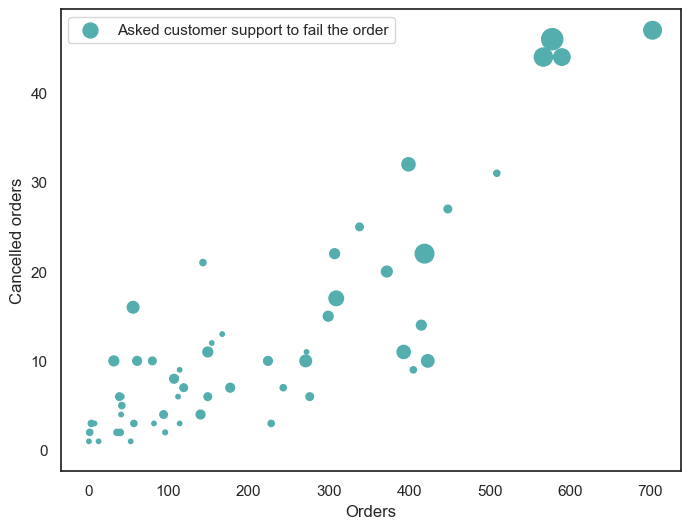

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(
    df_res.orders,
    df_res.cancelled,
    df_res.asked_to_cancel*10,
    label='Asked customer support to fail the order'
)
plt.xlabel('Orders')
plt.ylabel('Cancelled orders')
plt.legend()

This analysis reveals that the number of these cases increases as a restaurant receives more orders. While there are a few outliers from this trend, it remains a common practice in this market. Therefore, the next step is to engage with the market to gather more information about why this happens and how we can either mitigate this issue or adjust our scoring and recommendations systems to accommodate this market dynamic.